In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import bambi as bmb
import theano
import arviz as az
import os
cwd = os.getcwd() # Get direction
import warnings
warnings.filterwarnings('ignore')
import bayes_ame as ame
import R2_Bayes as r2

In [2]:
DF= pd.read_csv(cwd[:-4]+'/Data/data_farmclass_state.csv')

In [3]:
DF.columns

Index(['year', 'state_name', 'state_fips_code', 'domaincat_desc',
       'ACRES OPERATED', 'NUMBER OF OPERATIONS', 'farmcat', 'lower_bound',
       'upper_bound', '(EXCL CRP) - ACRES', 'DRAINED BY TILE - ACRES',
       '(EXCL CRP) - NUMBER OF OPERATIONS',
       'DRAINED BY TILE - NUMBER OF OPERATIONS', 'CROP INSURANCE - ACRES',
       'CROP INSURANCE - NUMBER OF OPERATIONS',
       'IRRIGATED - NUMBER OF OPERATIONS_x', 'RENTED FROM OTHERS_x',
       'RENTED FROM OTHERS_y', 'OWNED_x', 'OWNED_y', 'IRRIGATED - ACRES',
       'IRRIGATED - NUMBER OF OPERATIONS_y',
       'NET INCOME, MEASURED IN $ / OPERATION', 'FEDERAL - RECEIPTS',
       'FEDERAL - OPERATIONS WITH RECEIPTS', 'tot_income', 'income_ope',
       'STATE & LOCAL - RECEIPTS', 'STATE & LOCAL - OPERATIONS WITH RECEIPTS',
       'HIRED - EXPENSE', 'HIRED - OPERATIONS WITH EXPENSE',
       'CONTRACT - EXPENSE', 'CONTRACT - OPERATIONS WITH EXPENSE',
       'EXPENSE, MEASURED IN $', 'OPERATIONS WITH EXPENSE',
       'MACHINERY TOTAL

In [5]:
DF.groupby(['year','farm_class'])['fed_income'].mean()

year  farm_class
2012  Large         0.172622
      Medium       -1.127345
      Small        -0.646976
2017  Large         0.196665
      Medium        0.565023
      Small        -0.676095
2022  Large         0.178767
      Medium        0.739554
      Small         1.212221
Name: fed_income, dtype: float64

In [3]:
def dfsummary(trace):
    dfy= az.summary(trace)
    dfy['variables'] =dfy.index
    dfy['farm_class']= dfy.variables.str[-2:-1]
    
    return dfy

### Prepare data for Bayesian Models

In [4]:
DF.dropna(axis=0, how='any',subset=['cover_crops',
          'insured_farms','fed_income', 'statepay_ope', 
          'labor_expense','machinery_asset', 'rented_land',
          'grains_shareope', 'veggies_shareope','cattle_shareope',
           'tavg_z', 'pcp_mm_z', 'temp_var_z', 'edd_z', 'pcp_var_z', 'pcpdays_z'], inplace=True)

In [5]:
DF

,year,state_name,state_fips_code,domaincat_desc,ACRES OPERATED,NUMBER OF OPERATIONS,farmcat,lower_bound,upper_bound,(EXCL CRP) - ACRES,...,pcp_mm_std,pcpdays_mean,tavg_z,pcp_mm_z,temp_var_z,edd_z,pcp_var_z,pcpdays_z,tile_acres,irrigated_acres
0,2012,ALABAMA,1,AREA OPERATED: (1.0 TO 9.9 ACRES),14379.0,2919,1-10,1,9.0,139.0,...,146.310761,6.280597,0.530900,0.009962,-0.189443,0.786875,0.164086,0.137009,0.008624,0.040754
1,2012,ALABAMA,1,AREA OPERATED: (10.0 TO 49.9 ACRES),362197.0,13267,10-50,10,49.0,2651.0,...,146.310761,6.280597,0.530900,0.009962,-0.189443,0.786875,0.164086,0.137009,0.006635,0.005585
2,2012,ALABAMA,1,AREA OPERATED: (50.0 TO 69.9 ACRES),246346.0,4235,50-70,50,69.0,1984.0,...,146.310761,6.280597,0.530900,0.009962,-0.189443,0.786875,0.164086,0.137009,0.006962,0.003089
3,2012,ALABAMA,1,AREA OPERATED: (70.0 TO 99.9 ACRES),377435.0,4605,70-100,70,99.0,2921.0,...,146.310761,6.280597,0.530900,0.009962,-0.189443,0.786875,0.164086,0.137009,0.003534,0.003047
4,2012,ALABAMA,1,AREA OPERATED: (100 TO 139 ACRES),500043.0,4342,100-140,100,139.0,3569.0,...,146.310761,6.280597,0.530900,0.009962,-0.189443,0.786875,0.164086,0.137009,0.002068,0.003248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1723,2022,WYOMING,56,AREA OPERATED: (220 TO 259 ACRES),55708.0,234,220-260,220,259.0,641.0,...,86.960066,0.226087,0.220024,-0.226019,0.730746,-0.092792,-0.209423,-0.175208,0.013643,0.194083
1724,2022,WYOMING,56,AREA OPERATED: (260 TO 499 ACRES),320538.0,887,260-500,260,499.0,2525.0,...,86.960066,0.226087,0.220024,-0.226019,0.730746,-0.092792,-0.209423,-0.175208,0.025938,0.190764
1725,2022,WYOMING,56,AREA OPERATED: (500 TO 999 ACRES),619090.0,882,500-1K,500,999.0,5269.0,...,86.960066,0.226087,0.220024,-0.226019,0.730746,-0.092792,-0.209423,-0.175208,0.018844,0.149381
1726,2022,WYOMING,56,"AREA OPERATED: (1,000 TO 1,999 ACRES)",1102112.0,798,1K-2K,1000,1999.0,6328.0,...,86.960066,0.226087,0.220024,-0.226019,0.730746,-0.092792,-0.209423,-0.175208,0.011012,0.123741


In [6]:
# Keep counties with at least 2 observations
DF.sort_values(by= ['state_fips_code','farmcat','year'], inplace=True)
DF['cons']=1
DF['times']= DF.groupby(['state_fips_code','farmcat'])['cons'].transform(sum)

In [7]:
## Remove inf vals
DF.replace([np.inf, -np.inf], np.nan, inplace=True)
## Selected variables for inference
fe_vars= ['cover_crops',
          'insured_farms','fed_income', 'statepay_ope', 
          'labor_expense','machinery_asset', 'rented_land',
          'grains_shareope', 'veggies_shareope','cattle_shareope',
           'tavg_z',  'temp_var_z', 'edd_z','pcp_mm_z', 'pcp_var_z', 'pcpdays_z']
DF1= DF[['times','state_fips_code','year','farmcat','farm_class','class','year_2017', 'year_2022']+fe_vars]
DF1= DF1[DF1['times']>1] # select farm groups with more that 2 years of data

#Standardize variables within farm size and state groups
for x in fe_vars:    
    DF1[x+'_fe']= (DF1[x] - DF1.groupby(['state_fips_code','farmcat'])[x].transform('mean'))/(DF1.groupby(['state_fips_code','farmcat'])[x].transform('std'))
    


In [8]:
DF1

,times,state_fips_code,year,farmcat,farm_class,class,year_2017,year_2022,cover_crops,insured_farms,...,rented_land_fe,grains_shareope_fe,veggies_shareope_fe,cattle_shareope_fe,tavg_z_fe,temp_var_z_fe,edd_z_fe,pcp_mm_z_fe,pcp_var_z_fe,pcpdays_z_fe
0,3,1,2012,1-10,Small,0,0,0,0.009667,0.004796,...,1.150695,0.457649,-0.398855,-0.763454,0.915650,0.266232,1.154177,-1.052221,-0.152609,-1.011294
576,3,1,2017,1-10,Small,0,1,0,0.012307,0.007432,...,-0.658569,0.689281,-0.739021,-0.368509,-1.067078,-1.106173,-0.607197,0.114258,-0.914924,0.022984
1152,3,1,2022,1-10,Small,0,0,1,0.022588,0.011650,...,-0.492126,-1.146930,1.137876,1.131963,0.151428,0.839941,-0.546980,0.937963,1.067532,0.988310
1,3,1,2012,10-50,Small,0,0,0,0.007319,0.012588,...,0.034831,1.126181,0.969852,-0.815404,0.915650,0.266232,1.154177,-1.052221,-0.152609,-1.011294
577,3,1,2017,10-50,Small,0,1,0,0.009187,0.022078,...,0.982129,-0.783968,0.057789,1.115754,-1.067078,-1.106173,-0.607197,0.114258,-0.914924,0.022984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1143,3,56,2017,70-100,Small,0,1,0,0.012339,0.051650,...,1.129543,0.874407,1.109584,-0.159571,0.370678,-0.553948,-0.577350,1.038500,1.021817,0.698498
1719,3,56,2022,70-100,Small,0,0,1,0.012860,0.014730,...,-0.772376,-1.090319,-0.277992,1.070191,0.761735,1.154388,-0.577350,-0.956444,-0.976652,-1.145537
575,3,56,2012,>2K,Large,2,0,0,0.000937,0.220419,...,0.007434,-0.520680,0.483798,-0.884353,-1.132413,-0.600441,1.154701,-0.082055,-0.045165,0.447039
1151,3,56,2017,>2K,Large,2,1,0,0.000868,0.292461,...,-1.003696,-0.632224,-1.149894,1.085170,0.370678,-0.553948,-0.577350,1.038500,1.021817,0.698498


# Pooled model

In [9]:
# Priors
st_sd=1
priorsp = {
    'Intercept': bmb.Prior("Normal", mu= 0, sigma= st_sd),
    'insured_farms_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'fed_income_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'statepay_ope_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'labor_expense_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'rented_land_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'machinery_asset_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'grains_shareope_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'veggies_shareope_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'cattle_shareope_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'edd_z_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'pcpdays_z_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'temp_var_z_fe': bmb.Prior("Laplace", mu= 0, b= st_sd), 
    'pcp_var_z_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'tavg_z_fe': bmb.Prior("Laplace", mu= 0, b= st_sd), 
    'pcp_mm_z_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'year_2017': bmb.Prior('Laplace', mu= 0, b= st_sd),
    'year_2022': bmb.Prior('Laplace', mu= 0, b= st_sd),
    'sigma': bmb.Prior('HalfCauchy', beta= st_sd)
}

## Pooled model
modelp = bmb.Model("cover_crops_fe ~ 1+(insured_farms_fe)+\
       (fed_income_fe)+ (statepay_ope_fe)+(labor_expense_fe)+\
       (machinery_asset_fe)+ (rented_land_fe)+(grains_shareope_fe)+\
       (veggies_shareope_fe)+(cattle_shareope_fe)+(tavg_z_fe)+ (pcp_mm_z_fe)+(edd_z_fe)+(pcpdays_z_fe)+\
       (temp_var_z_fe) +(pcp_var_z_fe)+(year_2017)+(year_2022)", 
       DF1, priors= priorsp, dropna=True)
modelp

Automatically removing 53/1556 rows from the dataset.


Formula: cover_crops_fe ~ 1+(insured_farms_fe)+       (fed_income_fe)+ (statepay_ope_fe)+(labor_expense_fe)+       (machinery_asset_fe)+ (rented_land_fe)+(grains_shareope_fe)+       (veggies_shareope_fe)+(cattle_shareope_fe)+(tavg_z_fe)+ (pcp_mm_z_fe)+(edd_z_fe)+(pcpdays_z_fe)+       (temp_var_z_fe) +(pcp_var_z_fe)+(year_2017)+(year_2022)
Family name: Gaussian
Link: identity
Observations: 1503
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 1)
    insured_farms_fe ~ Laplace(mu: 0, b: 1)
    fed_income_fe ~ Laplace(mu: 0, b: 1)
    statepay_ope_fe ~ Laplace(mu: 0, b: 1)
    labor_expense_fe ~ Laplace(mu: 0, b: 1)
    machinery_asset_fe ~ Laplace(mu: 0, b: 1)
    rented_land_fe ~ Laplace(mu: 0, b: 1)
    grains_shareope_fe ~ Laplace(mu: 0, b: 1)
    veggies_shareope_fe ~ Laplace(mu: 0, b: 1)
    cattle_shareope_fe ~ Laplace(mu: 0, b: 1)
    tavg_z_fe ~ Laplace(mu: 0, b: 1)
    pcp_mm_z_fe ~ Laplace(mu: 0, b: 1)
    edd_z_fe ~ Laplace(mu: 0, b: 1)
    pcpdays_z_fe ~ La

In [10]:
tracep = modelp.fit(tune=1000, draws=1000, init="adapt_diag",target_accept=.99,random_seed=21)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cover_crops_fe_sigma, Intercept, year_2022, year_2017, pcp_var_z_fe, temp_var_z_fe, pcpdays_z_fe, edd_z_fe, pcp_mm_z_fe, tavg_z_fe, cattle_shareope_fe, veggies_shareope_fe, grains_shareope_fe, rented_land_fe, machinery_asset_fe, labor_expense_fe, statepay_ope_fe, fed_income_fe, insured_farms_fe]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 99 seconds.


In [22]:
az.loo(tracep)

Computed from 4000 posterior samples and 1298 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1404.69    19.62
p_loo       19.14        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     1298  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [11]:
az.summary(tracep)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.493,0.046,-0.582,-0.407,0.001,0.001,2056.0,2521.0,1.0
insured_farms_fe,0.111,0.025,0.064,0.157,0.000,0.000,2845.0,3037.0,1.0
fed_income_fe,0.008,0.022,-0.032,0.049,0.000,0.000,3851.0,3419.0,1.0
statepay_ope_fe,0.061,0.020,0.022,0.099,0.000,0.000,4076.0,3083.0,1.0
labor_expense_fe,-0.016,0.023,-0.058,0.029,0.000,0.000,4303.0,3139.0,1.0
machinery_asset_fe,0.002,0.021,-0.039,0.041,0.000,0.000,4258.0,3208.0,1.0
rented_land_fe,0.039,0.025,-0.010,0.086,0.000,0.000,4054.0,2920.0,1.0
grains_shareope_fe,0.016,0.022,-0.025,0.055,0.000,0.000,4170.0,3359.0,1.0
veggies_shareope_fe,0.009,0.020,-0.029,0.046,0.000,0.000,5005.0,3056.0,1.0
cattle_shareope_fe,-0.062,0.023,-0.105,-0.016,0.000,0.000,4246.0,3171.0,1.0


In [25]:

DF1['cons']=1

selvars=['cons',
        'insured_farms_fe','fed_income_fe', 'statepay_ope_fe', 
        'labor_expense_fe','machinery_asset_fe', 'rented_land_fe',
        'grains_shareope_fe', 'veggies_shareope_fe','cattle_shareope_fe',
        'tavg_z_fe','pcp_mm_z_fe','edd_z_fe', 'pcpdays_z_fe', 'temp_var_z_fe',  'pcp_var_z_fe',
         'year_2017','year_2022']


varspost= ['Intercept',
        'insured_farms_fe','fed_income_fe', 'statepay_ope_fe', 
        'labor_expense_fe','machinery_asset_fe', 'rented_land_fe',
        'grains_shareope_fe', 'veggies_shareope_fe','cattle_shareope_fe',
        'tavg_z_fe','pcp_mm_z_fe', 'edd_z_fe', 'pcpdays_z_fe','temp_var_z_fe',  'pcp_var_z_fe',
           'year_2017','year_2022']

DF1_clean= DF1
DF1_clean.dropna(axis=0, how='any',subset=['cover_crops_fe',
        'insured_farms_fe','fed_income_fe', 'statepay_ope_fe', 
        'labor_expense_fe','machinery_asset_fe', 'rented_land_fe',
        'grains_shareope_fe', 'veggies_shareope_fe','cattle_shareope_fe',
        'tavg_z_fe','pcp_mm_z_fe','edd_z_fe', 'pcpdays_z_fe', 'temp_var_z_fe',  'pcp_var_z_fe',
        'year_2017','year_2022'], inplace=True)


In [20]:
meanp, lcip, ucip= r2.Bayesian_Rsquared(DF1_clean, 'identity',tracep, 'cover_crops_fe',selvars,varspost, False, x,4,1000,x)

In [22]:
print('Mean CI:', meanp)
print('Lower CI:', lcip)
print('Upper CI:', ucip)

Mean CI: 0.4418013424495645
Lower CI: 0.4140735222692653
Upper CI: 0.4681376347221799


In [26]:
print(az.hdi(tracep,var_names=varspost[:12], hdi_prob = 0.99).values())
print(az.hdi(tracep,var_names=varspost[12:], hdi_prob = 0.99).values())

ValuesView(<xarray.Dataset>
Dimensions:              (hdi: 2)
Coordinates:
  * hdi                  (hdi) <U6 'lower' 'higher'
Data variables:
    Intercept            (hdi) float64 -0.6107 -0.3727
    insured_farms_fe     (hdi) float64 0.04452 0.1719
    fed_income_fe        (hdi) float64 -0.04792 0.06219
    statepay_ope_fe      (hdi) float64 0.01227 0.1148
    labor_expense_fe     (hdi) float64 -0.07652 0.04105
    machinery_asset_fe   (hdi) float64 -0.05253 0.05693
    rented_land_fe       (hdi) float64 -0.02661 0.1052
    grains_shareope_fe   (hdi) float64 -0.04076 0.06867
    veggies_shareope_fe  (hdi) float64 -0.04685 0.05747
    cattle_shareope_fe   (hdi) float64 -0.1246 -0.005575
    tavg_z_fe            (hdi) float64 -0.1461 0.005084
    pcp_mm_z_fe          (hdi) float64 -0.2083 -0.04554)
ValuesView(<xarray.Dataset>
Dimensions:        (hdi: 2)
Coordinates:
  * hdi            (hdi) <U6 'lower' 'higher'
Data variables:
    edd_z_fe       (hdi) float64 -0.2397 -0.06224
    pcpd

In [27]:
print(az.hdi(tracep,var_names=varspost[:12], hdi_prob = 0.90).values())
print(az.hdi(tracep,var_names=varspost[12:], hdi_prob = 0.90).values())

ValuesView(<xarray.Dataset>
Dimensions:              (hdi: 2)
Coordinates:
  * hdi                  (hdi) <U6 'lower' 'higher'
Data variables:
    Intercept            (hdi) float64 -0.5673 -0.4127
    insured_farms_fe     (hdi) float64 0.07019 0.1522
    fed_income_fe        (hdi) float64 -0.02855 0.04248
    statepay_ope_fe      (hdi) float64 0.02652 0.09261
    labor_expense_fe     (hdi) float64 -0.05091 0.02618
    machinery_asset_fe   (hdi) float64 -0.03222 0.03729
    rented_land_fe       (hdi) float64 -0.001014 0.08184
    grains_shareope_fe   (hdi) float64 -0.01991 0.05024
    veggies_shareope_fe  (hdi) float64 -0.02491 0.0412
    cattle_shareope_fe   (hdi) float64 -0.1002 -0.02417
    tavg_z_fe            (hdi) float64 -0.1202 -0.0217
    pcp_mm_z_fe          (hdi) float64 -0.1787 -0.07473)
ValuesView(<xarray.Dataset>
Dimensions:        (hdi: 2)
Coordinates:
  * hdi            (hdi) <U6 'lower' 'higher'
Data variables:
    edd_z_fe       (hdi) float64 -0.2035 -0.09414
    pcpd

# Hierarchical model 

In [13]:
st_sd= 1 #bmb.Prior("HalfCauchy", beta= 1)


priorsc = {
    '1|class': bmb.Prior("Normal", mu= 0, sigma= st_sd),
    'insured_farms_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'fed_income_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'statepay_ope_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'labor_expense_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'rented_land_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'machinery_asset_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'grains_shareope_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'veggies_shareope_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'cattle_shareope_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'edd_z_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'pcpdays_z_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'temp_var_z_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd), 
    'pcp_var_z_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'tavg_z_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd), 
    'pcp_mm_z_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'year_2017|class': bmb.Prior('Laplace', mu= 0, b= st_sd),
    'year_2022|class': bmb.Prior('Laplace', mu= 0, b= st_sd),
    'sigma': bmb.Prior('HalfCauchy', beta= 1)
}


In [14]:
model = bmb.Model("cover_crops_fe ~ 0+(1|class)+ (insured_farms_fe|class)+\
       (fed_income_fe|class)+ (statepay_ope_fe|class)+(labor_expense_fe|class)+\
       (machinery_asset_fe|class)+ (rented_land_fe|class)+(grains_shareope_fe|class)+\
       (veggies_shareope_fe|class)+(cattle_shareope_fe|class)+\
       (tavg_z_fe|class) + (pcp_mm_z_fe|class) + (temp_var_z_fe|class)+\
       (pcp_var_z_fe|class) + (edd_z_fe|class) + (pcpdays_z_fe|class) +\
       (year_2017|class)+ (year_2022|class)", 
        DF1, priors= priorsc, dropna=True)
#
model

Formula: cover_crops_fe ~ 0+(1|class)+ (insured_farms_fe|class)+       (fed_income_fe|class)+ (statepay_ope_fe|class)+(labor_expense_fe|class)+       (machinery_asset_fe|class)+ (rented_land_fe|class)+(grains_shareope_fe|class)+       (veggies_shareope_fe|class)+(cattle_shareope_fe|class)+       (tavg_z_fe|class) + (pcp_mm_z_fe|class) + (temp_var_z_fe|class)+       (pcp_var_z_fe|class) + (edd_z_fe|class) + (pcpdays_z_fe|class) +       (year_2017|class)+ (year_2022|class)
Family name: Gaussian
Link: identity
Observations: 1503
Priors:
  Group-level effects
    1|class ~ Normal(mu: 0, sigma: 1)
    insured_farms_fe|class ~ Laplace(mu: 0, b: 1)
    fed_income_fe|class ~ Laplace(mu: 0, b: 1)
    statepay_ope_fe|class ~ Laplace(mu: 0, b: 1)
    labor_expense_fe|class ~ Laplace(mu: 0, b: 1)
    machinery_asset_fe|class ~ Laplace(mu: 0, b: 1)
    rented_land_fe|class ~ Laplace(mu: 0, b: 1)
    grains_shareope_fe|class ~ Laplace(mu: 0, b: 1)
    veggies_shareope_fe|class ~ Laplace(mu: 0, b: 1)

In [15]:
trace = model.fit(tune=1000, draws=1000, init="adapt_diag",target_accept=.99,random_seed=21)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cover_crops_fe_sigma, year_2022|class, year_2017|class, pcpdays_z_fe|class, edd_z_fe|class, pcp_var_z_fe|class, temp_var_z_fe|class, pcp_mm_z_fe|class, tavg_z_fe|class, cattle_shareope_fe|class, veggies_shareope_fe|class, grains_shareope_fe|class, rented_land_fe|class, machinery_asset_fe|class, labor_expense_fe|class, statepay_ope_fe|class, fed_income_fe|class, insured_farms_fe|class, 1|class]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 300 seconds.


In [16]:
df= dfsummary(trace)
df[df['farm_class']== '0']

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,variables,farm_class
1|class[0],-0.548,0.081,-0.697,-0.397,0.002,0.001,1938.0,2338.0,1.0,1|class[0],0
insured_farms_fe|class[0],0.087,0.048,0.002,0.180,0.001,0.001,3252.0,3089.0,1.0,insured_farms_fe|class[0],0
fed_income_fe|class[0],-0.020,0.037,-0.095,0.046,0.001,0.001,5524.0,2940.0,1.0,fed_income_fe|class[0],0
statepay_ope_fe|class[0],0.028,0.035,-0.037,0.095,0.000,0.001,8138.0,2609.0,1.0,statepay_ope_fe|class[0],0
labor_expense_fe|class[0],0.023,0.036,-0.044,0.091,0.000,0.000,6279.0,3332.0,1.0,labor_expense_fe|class[0],0
machinery_asset_fe|class[0],-0.051,0.037,-0.118,0.018,0.000,0.000,6555.0,2394.0,1.0,machinery_asset_fe|class[0],0
rented_land_fe|class[0],0.049,0.049,-0.043,0.140,0.001,0.001,3703.0,3028.0,1.0,rented_land_fe|class[0],0
grains_shareope_fe|class[0],0.007,0.037,-0.059,0.079,0.000,0.001,6834.0,2985.0,1.0,grains_shareope_fe|class[0],0
veggies_shareope_fe|class[0],0.036,0.035,-0.030,0.103,0.000,0.000,7586.0,3056.0,1.0,veggies_shareope_fe|class[0],0
cattle_shareope_fe|class[0],-0.153,0.042,-0.233,-0.073,0.001,0.000,6293.0,3269.0,1.0,cattle_shareope_fe|class[0],0


In [17]:
df[df['farm_class']== '1']

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,variables,farm_class
1|class[1],-0.387,0.086,-0.554,-0.233,0.002,0.001,2102.0,2442.0,1.0,1|class[1],1
insured_farms_fe|class[1],0.123,0.045,0.040,0.208,0.001,0.001,3694.0,3063.0,1.0,insured_farms_fe|class[1],1
fed_income_fe|class[1],0.001,0.041,-0.076,0.082,0.001,0.001,4556.0,2661.0,1.0,fed_income_fe|class[1],1
statepay_ope_fe|class[1],0.026,0.034,-0.036,0.091,0.000,0.000,6904.0,2858.0,1.0,statepay_ope_fe|class[1],1
labor_expense_fe|class[1],-0.065,0.041,-0.142,0.009,0.001,0.000,5103.0,3305.0,1.0,labor_expense_fe|class[1],1
machinery_asset_fe|class[1],0.031,0.039,-0.037,0.106,0.000,0.001,6170.0,2984.0,1.0,machinery_asset_fe|class[1],1
rented_land_fe|class[1],-0.058,0.048,-0.150,0.032,0.001,0.001,5286.0,3181.0,1.0,rented_land_fe|class[1],1
grains_shareope_fe|class[1],0.103,0.040,0.025,0.176,0.001,0.000,4489.0,2956.0,1.0,grains_shareope_fe|class[1],1
veggies_shareope_fe|class[1],0.003,0.035,-0.060,0.072,0.000,0.001,7959.0,2797.0,1.0,veggies_shareope_fe|class[1],1
cattle_shareope_fe|class[1],0.004,0.041,-0.074,0.080,0.000,0.001,7054.0,2916.0,1.0,cattle_shareope_fe|class[1],1


In [18]:
df[df['farm_class']== '2']

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,variables,farm_class
1|class[2],-0.506,0.085,-0.664,-0.350,0.002,0.001,1983.0,2575.0,1.0,1|class[2],2
insured_farms_fe|class[2],0.087,0.044,0.007,0.171,0.001,0.000,5186.0,3240.0,1.0,insured_farms_fe|class[2],2
fed_income_fe|class[2],-0.036,0.041,-0.112,0.039,0.001,0.001,5098.0,3319.0,1.0,fed_income_fe|class[2],2
statepay_ope_fe|class[2],0.101,0.036,0.036,0.171,0.000,0.000,5800.0,3424.0,1.0,statepay_ope_fe|class[2],2
labor_expense_fe|class[2],-0.015,0.048,-0.104,0.073,0.001,0.001,3608.0,3009.0,1.0,labor_expense_fe|class[2],2
machinery_asset_fe|class[2],0.015,0.044,-0.064,0.097,0.001,0.001,5919.0,3489.0,1.0,machinery_asset_fe|class[2],2
rented_land_fe|class[2],0.111,0.041,0.040,0.192,0.001,0.000,5901.0,2703.0,1.0,rented_land_fe|class[2],2
grains_shareope_fe|class[2],-0.058,0.040,-0.134,0.016,0.001,0.000,5923.0,3172.0,1.0,grains_shareope_fe|class[2],2
veggies_shareope_fe|class[2],-0.002,0.036,-0.070,0.068,0.000,0.001,6523.0,3325.0,1.0,veggies_shareope_fe|class[2],2
cattle_shareope_fe|class[2],-0.027,0.039,-0.097,0.050,0.001,0.001,5663.0,3027.0,1.0,cattle_shareope_fe|class[2],2


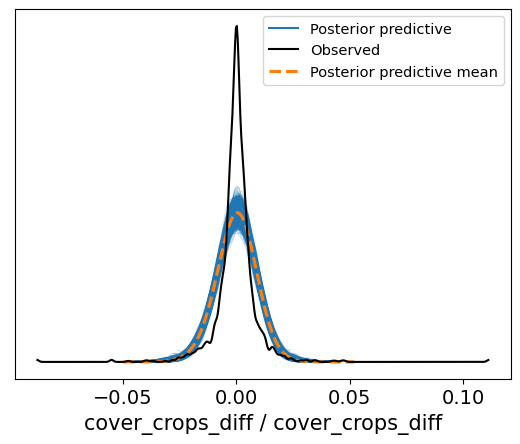

In [110]:
model.predict(trace, kind="pps")
az.plot_ppc(trace);

In [64]:
az.loo(trace)

Computed from 4000 posterior samples and 1268 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1331.13    21.48
p_loo       53.99        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     1268  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

## R2 

In [28]:

DF1['cons']=1
selvars=['cons',
        'insured_farms_fe','fed_income_fe', 'statepay_ope_fe', 
        'labor_expense_fe','machinery_asset_fe', 'rented_land_fe',
        'grains_shareope_fe', 'veggies_shareope_fe','cattle_shareope_fe',
        'tavg_z_fe','pcp_mm_z_fe','edd_z_fe','pcpdays_z_fe',
         'temp_var_z_fe', 'pcp_var_z_fe',
         'year_2017','year_2022']


varspost= ['1|class',
        'insured_farms_fe|class','fed_income_fe|class', 'statepay_ope_fe|class', 
        'labor_expense_fe|class','machinery_asset_fe|class', 'rented_land_fe|class',
        'grains_shareope_fe|class', 'veggies_shareope_fe|class','cattle_shareope_fe|class',
        'tavg_z_fe|class','pcp_mm_z_fe|class','edd_z_fe|class','pcpdays_z_fe|class',
        'temp_var_z_fe|class', 'pcp_var_z_fe|class',
           'year_2017|class','year_2022|class']

DF1_clean= DF1
DF1_clean.dropna(axis=0, how='any',subset=['cover_crops_fe',
        'insured_farms_fe','fed_income_fe', 'statepay_ope_fe', 
        'labor_expense_fe','machinery_asset_fe', 'rented_land_fe',
        'grains_shareope_fe', 'veggies_shareope_fe','cattle_shareope_fe',
        'tavg_z_fe','pcp_mm_z_fe','edd_z_fe','pcpdays_z_fe',
        'temp_var_z_fe', 'pcp_var_z_fe','year_2017','year_2022'], inplace=True)

In [34]:
mean, lci, uci= r2.Bayesian_Rsquared(DF1_clean,'identity', trace, 'cover_crops_fe',selvars,varspost, True, 'class', 4, 1000, 3)
print('Mean CI:', meanp)
print('Lower CI:', lcip)
print('Upper CI:', ucip)

Mean CI: 0.4418013424495645
Lower CI: 0.4140735222692653
Upper CI: 0.4681376347221799


In [29]:
print(az.hdi(trace,var_names=varspost[:12], hdi_prob = 0.99).sel(class_coord_group_factor='0'))
print(az.hdi(trace,var_names=varspost[12:], hdi_prob = 0.99).sel(class_coord_group_factor='0'))

<xarray.Dataset>
Dimensions:                    (hdi: 2)
Coordinates:
    class_coord_group_factor   <U1 '0'
  * hdi                        (hdi) <U6 'lower' 'higher'
Data variables:
    1|class                    (hdi) float64 -0.7541 -0.3442
    insured_farms_fe|class     (hdi) float64 -0.03688 0.2091
    fed_income_fe|class        (hdi) float64 -0.1118 0.07439
    statepay_ope_fe|class      (hdi) float64 -0.06503 0.12
    labor_expense_fe|class     (hdi) float64 -0.07164 0.1156
    machinery_asset_fe|class   (hdi) float64 -0.1484 0.04561
    rented_land_fe|class       (hdi) float64 -0.07234 0.1767
    grains_shareope_fe|class   (hdi) float64 -0.08906 0.0999
    veggies_shareope_fe|class  (hdi) float64 -0.05698 0.1277
    cattle_shareope_fe|class   (hdi) float64 -0.2626 -0.04525
    tavg_z_fe|class            (hdi) float64 -0.2174 0.04372
    pcp_mm_z_fe|class          (hdi) float64 -0.1517 0.1233
<xarray.Dataset>
Dimensions:                   (hdi: 2)
Coordinates:
    class_coord_gr

In [32]:
print(az.hdi(trace,var_names=varspost[:12], hdi_prob = 0.90).sel(class_coord_group_factor='0'))
print(az.hdi(trace,var_names=varspost[12:], hdi_prob = 0.90).sel(class_coord_group_factor='0'))

<xarray.Dataset>
Dimensions:                    (hdi: 2)
Coordinates:
    class_coord_group_factor   <U1 '0'
  * hdi                        (hdi) <U6 'lower' 'higher'
Data variables:
    1|class                    (hdi) float64 -0.6675 -0.3997
    insured_farms_fe|class     (hdi) float64 0.01189 0.1674
    fed_income_fe|class        (hdi) float64 -0.0797 0.04337
    statepay_ope_fe|class      (hdi) float64 -0.0348 0.07997
    labor_expense_fe|class     (hdi) float64 -0.0358 0.08128
    machinery_asset_fe|class   (hdi) float64 -0.1121 0.007528
    rented_land_fe|class       (hdi) float64 -0.03061 0.128
    grains_shareope_fe|class   (hdi) float64 -0.05431 0.06603
    veggies_shareope_fe|class  (hdi) float64 -0.02173 0.09439
    cattle_shareope_fe|class   (hdi) float64 -0.2263 -0.08676
    tavg_z_fe|class            (hdi) float64 -0.1712 -0.0001591
    pcp_mm_z_fe|class          (hdi) float64 -0.1071 0.06339
<xarray.Dataset>
Dimensions:                   (hdi: 2)
Coordinates:
    class_c

In [30]:
print(az.hdi(trace,var_names=varspost[:12], hdi_prob = 0.99).sel(class_coord_group_factor='1'))
print(az.hdi(trace,var_names=varspost[12:], hdi_prob = 0.99).sel(class_coord_group_factor='1'))

<xarray.Dataset>
Dimensions:                    (hdi: 2)
Coordinates:
    class_coord_group_factor   <U1 '1'
  * hdi                        (hdi) <U6 'lower' 'higher'
Data variables:
    1|class                    (hdi) float64 -0.6144 -0.1713
    insured_farms_fe|class     (hdi) float64 0.009747 0.234
    fed_income_fe|class        (hdi) float64 -0.1075 0.1062
    statepay_ope_fe|class      (hdi) float64 -0.05865 0.1112
    labor_expense_fe|class     (hdi) float64 -0.1654 0.03669
    machinery_asset_fe|class   (hdi) float64 -0.06054 0.1368
    rented_land_fe|class       (hdi) float64 -0.1756 0.06814
    grains_shareope_fe|class   (hdi) float64 -0.0005135 0.2035
    veggies_shareope_fe|class  (hdi) float64 -0.09282 0.0939
    cattle_shareope_fe|class   (hdi) float64 -0.1023 0.1127
    tavg_z_fe|class            (hdi) float64 -0.1609 0.09703
    pcp_mm_z_fe|class          (hdi) float64 -0.3196 -0.04211
<xarray.Dataset>
Dimensions:                   (hdi: 2)
Coordinates:
    class_coord_

In [33]:
print(az.hdi(trace,var_names=varspost[:12], hdi_prob = 0.90).sel(class_coord_group_factor='1'))
print(az.hdi(trace,var_names=varspost[12:], hdi_prob = 0.90).sel(class_coord_group_factor='1'))

<xarray.Dataset>
Dimensions:                    (hdi: 2)
Coordinates:
    class_coord_group_factor   <U1 '1'
  * hdi                        (hdi) <U6 'lower' 'higher'
Data variables:
    1|class                    (hdi) float64 -0.5217 -0.2399
    insured_farms_fe|class     (hdi) float64 0.0519 0.1988
    fed_income_fe|class        (hdi) float64 -0.0718 0.06564
    statepay_ope_fe|class      (hdi) float64 -0.03273 0.07978
    labor_expense_fe|class     (hdi) float64 -0.1291 0.005672
    machinery_asset_fe|class   (hdi) float64 -0.02704 0.09866
    rented_land_fe|class       (hdi) float64 -0.1354 0.02355
    grains_shareope_fe|class   (hdi) float64 0.04051 0.1716
    veggies_shareope_fe|class  (hdi) float64 -0.05193 0.06375
    cattle_shareope_fe|class   (hdi) float64 -0.06143 0.07177
    tavg_z_fe|class            (hdi) float64 -0.1141 0.05335
    pcp_mm_z_fe|class          (hdi) float64 -0.2733 -0.09579
<xarray.Dataset>
Dimensions:                   (hdi: 2)
Coordinates:
    class_coo

In [31]:
print(az.hdi(trace,var_names=varspost[:12], hdi_prob = 0.99).sel(class_coord_group_factor='2'))
print(az.hdi(trace,var_names=varspost[12:], hdi_prob = 0.99).sel(class_coord_group_factor='2'))

<xarray.Dataset>
Dimensions:                    (hdi: 2)
Coordinates:
    class_coord_group_factor   <U1 '2'
  * hdi                        (hdi) <U6 'lower' 'higher'
Data variables:
    1|class                    (hdi) float64 -0.7325 -0.2918
    insured_farms_fe|class     (hdi) float64 -0.02476 0.1999
    fed_income_fe|class        (hdi) float64 -0.1417 0.06542
    statepay_ope_fe|class      (hdi) float64 0.008846 0.1875
    labor_expense_fe|class     (hdi) float64 -0.1386 0.1002
    machinery_asset_fe|class   (hdi) float64 -0.0943 0.1335
    rented_land_fe|class       (hdi) float64 0.006669 0.2194
    grains_shareope_fe|class   (hdi) float64 -0.156 0.04061
    veggies_shareope_fe|class  (hdi) float64 -0.0936 0.09589
    cattle_shareope_fe|class   (hdi) float64 -0.1316 0.06773
    tavg_z_fe|class            (hdi) float64 -0.2957 -0.02776
    pcp_mm_z_fe|class          (hdi) float64 -0.3671 -0.0886
<xarray.Dataset>
Dimensions:                   (hdi: 2)
Coordinates:
    class_coord_gr

In [35]:
print(az.hdi(trace,var_names=varspost[:12], hdi_prob = 0.90).sel(class_coord_group_factor='2'))
print(az.hdi(trace,var_names=varspost[12:], hdi_prob = 0.90).sel(class_coord_group_factor='2'))

<xarray.Dataset>
Dimensions:                    (hdi: 2)
Coordinates:
    class_coord_group_factor   <U1 '2'
  * hdi                        (hdi) <U6 'lower' 'higher'
Data variables:
    1|class                    (hdi) float64 -0.6476 -0.3715
    insured_farms_fe|class     (hdi) float64 0.01037 0.1533
    fed_income_fe|class        (hdi) float64 -0.1021 0.03082
    statepay_ope_fe|class      (hdi) float64 0.04001 0.1582
    labor_expense_fe|class     (hdi) float64 -0.09351 0.06219
    machinery_asset_fe|class   (hdi) float64 -0.0618 0.08125
    rented_land_fe|class       (hdi) float64 0.04756 0.1804
    grains_shareope_fe|class   (hdi) float64 -0.1249 0.007867
    veggies_shareope_fe|class  (hdi) float64 -0.0608 0.05967
    cattle_shareope_fe|class   (hdi) float64 -0.08985 0.03766
    tavg_z_fe|class            (hdi) float64 -0.2373 -0.06151
    pcp_mm_z_fe|class          (hdi) float64 -0.3148 -0.1309
<xarray.Dataset>
Dimensions:                   (hdi: 2)
Coordinates:
    class_coord

### Model comparison

In [36]:
az.compare({"main": trace, "pooled": tracep})#, 'state effects': trace_cc2})

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
main,0,-1401.901376,57.654896,0.000000,0.49894,29.924366,0.000000,False,log
pooled,1,-1401.930338,19.940973,0.028962,0.50106,29.938983,8.630115,False,log


In [37]:
print('Lower Bound: ', 0.028962-8.630115*2.92)
print('Upper Bound: ', 0.028962+8.630115*2.92)


Lower Bound:  -25.1709738
Upper Bound:  25.2288978


In [133]:
#ppc = pm.sample_posterior_predictive(trace_cc, samples=1000, model=modelcc)
#post_samples = np.asarray(ppc['cover_crops'])